# Time Series Forecasting
Time Series Forecasting means analyzing and modeling time-series data to make future decisions. Some of the applications of Time Series Forecasting are weather forecasting, sales forecasting, business forecasting, stock price forecasting, etc. 

# Importing Libraries


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from datetime import date, timedelta
today=date.today()

We will first collect Gold price data using the Yahoo Finance API.

In [5]:
d1=today.strftime('%Y-%m-%d')
end_date=d1
d2=date.today()-timedelta(days=360)
d2=d2.strftime('%Y-%m-%d')
start_date=d2

In [6]:
dataset=yf.download('GC=F', start=start_date,
                   end=end_date, progress=False)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-04,1764.500000,1768.900024,1749.500000,1766.199951,1766.199951,417
2021-10-05,1764.300049,1764.300049,1749.000000,1759.599976,1759.599976,98
2021-10-06,1759.300049,1762.900024,1744.699951,1760.500000,1760.500000,56
2021-10-07,1762.400024,1762.400024,1752.800049,1757.900024,1757.900024,336
2021-10-08,1757.000000,1780.000000,1754.199951,1756.300049,1756.300049,254


In [7]:
dataset['Date']=dataset.index
dataset=dataset[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-04,1764.500000,1768.900024,1749.500000,1766.199951,1766.199951,417
1,2021-10-05,1764.300049,1764.300049,1749.000000,1759.599976,1759.599976,98
2,2021-10-06,1759.300049,1762.900024,1744.699951,1760.500000,1760.500000,56
3,2021-10-07,1762.400024,1762.400024,1752.800049,1757.900024,1757.900024,336
4,2021-10-08,1757.000000,1780.000000,1754.199951,1756.300049,1756.300049,254


We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further

In [8]:
dataset=dataset[['Date', 'Close']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    248 non-null    datetime64[ns]
 1   Close   248 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


Now let’s visualize the close prices of Gold before moving forward

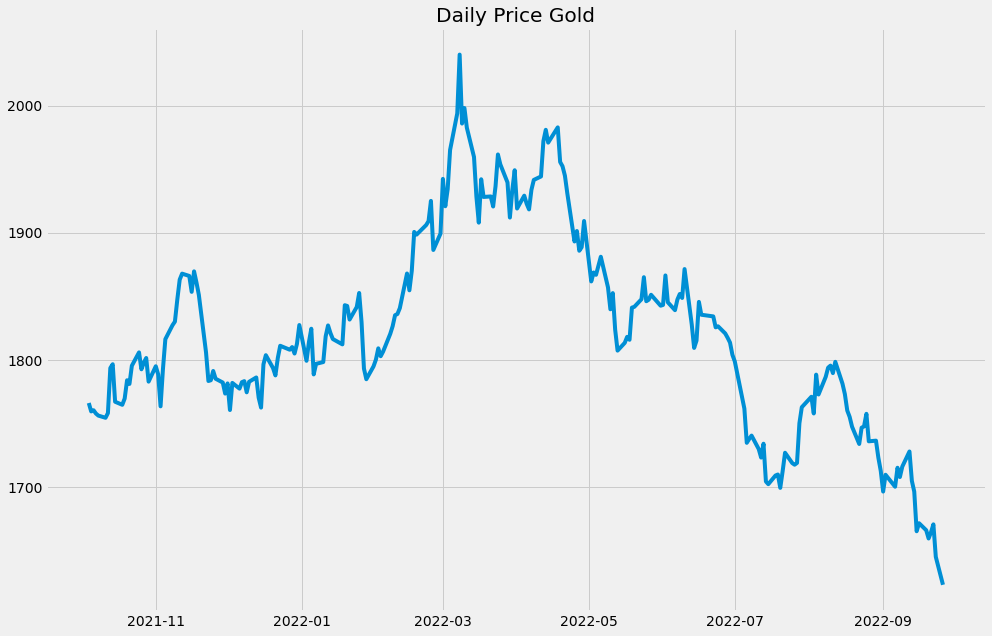

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,10))
plt.plot(dataset['Date'], dataset['Close'])
plt.title('Daily Price Gold')
plt.show()

## Our Data Stationary or Seasonal?

Before using model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing Gold prices above shows that our dataset is not stationary. To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data

<Figure size 432x288 with 0 Axes>

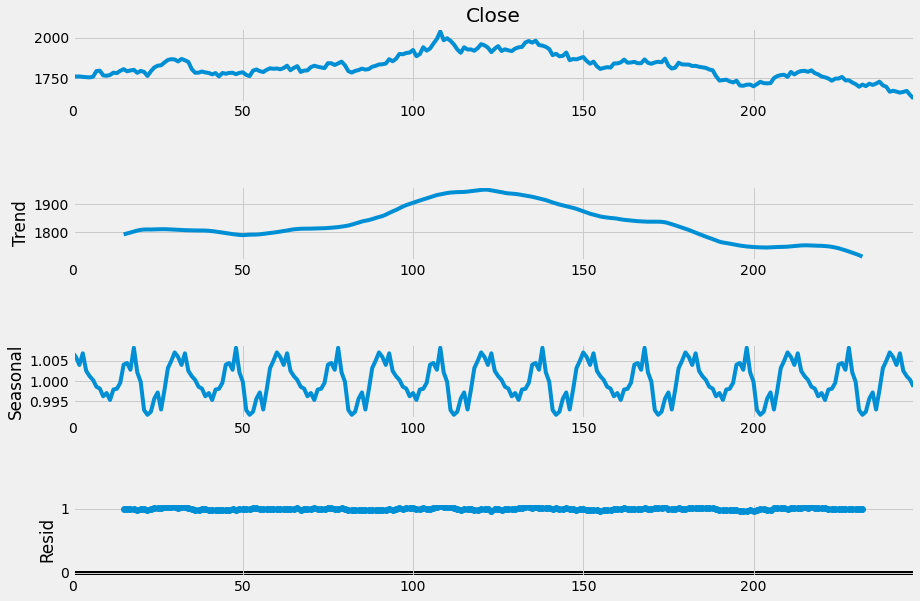

In [10]:
result = seasonal_decompose(dataset['Close'], model='multiplicative', period=30)
fig=plt.figure()
fig=result.plot()
fig.set_size_inches(15,10)

From graph above we can take conclution our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. Or we can use adfuller function to know whether our data seasonal or stationary

In [18]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dataset['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.824741
p-value: 0.811746
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


if our data p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary(seasonal) and if our data p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

# SARIMA

To use SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

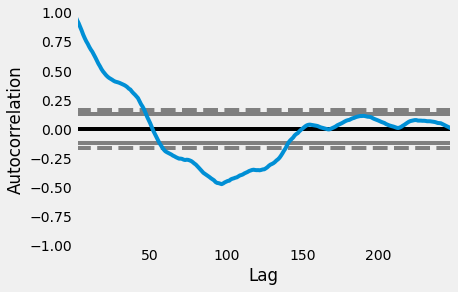

In [12]:
pd.plotting.autocorrelation_plot(dataset['Close'])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5

C:\Users\Reskur\anaconda3\envs\dqlabml_iki\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


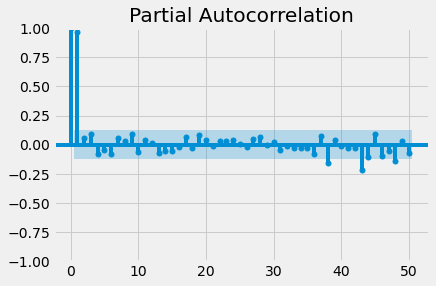

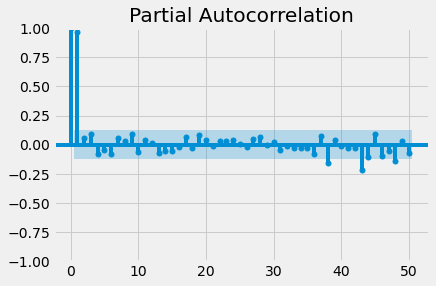

In [13]:
plot_pacf(dataset['Close'], lags=50)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2

# Build Sarima Model

In [14]:
p,d,q = 5,1,2
import warnings
model = sm.tsa.statespace.SARIMAX(dataset['Close'], order=(p,d,q), seasonal_order=(p,d,q,12))
model = model.fit()
print(model.summary())

C:\Users\Reskur\anaconda3\envs\dqlabml_iki\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  248
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -1007.007
Date:                            Wed, 28 Sep 2022   AIC                           2044.014
Time:                                    10:44:08   BIC                           2095.907
Sample:                                         0   HQIC                          2064.935
                                            - 248                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5828      0.074    -21.303      0.000      -1.728      -1.437
ar.L2         -1.0629      0.124   

Now let’s predict the future Gold prices using the SARIMA model for the next 10 days

In [15]:
predictions = model.predict(len(dataset), len(dataset)+10)
print(predictions)

248    1624.625786
249    1625.314941
250    1618.855640
251    1624.187353
252    1627.500738
253    1624.514092
254    1623.916519
255    1617.563959
256    1624.250696
257    1620.163556
258    1620.261205
Name: predicted_mean, dtype: float64


<AxesSubplot:>

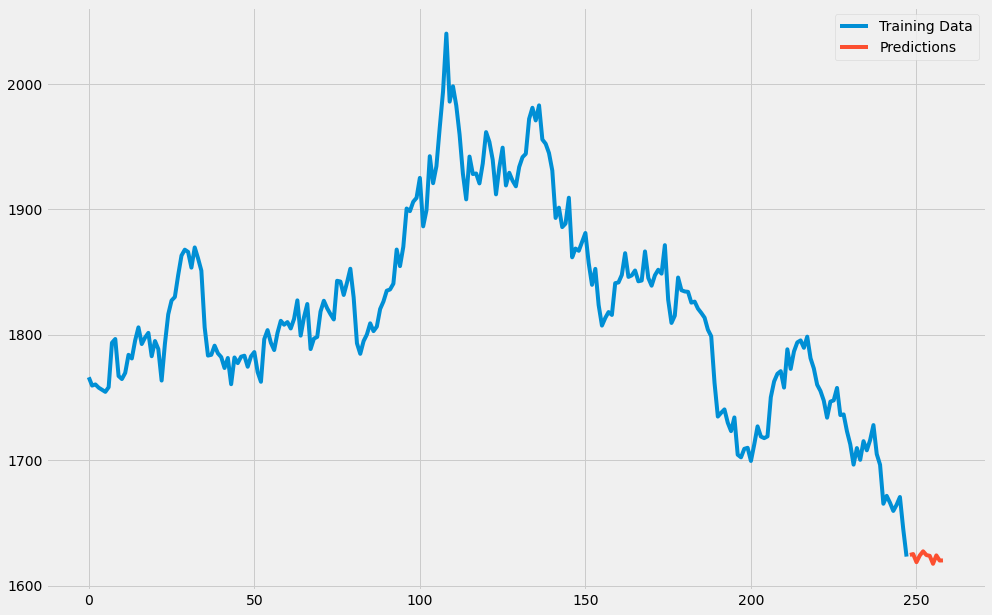

In [16]:
dataset['Close'].plot(legend=True, label='Training Data', figsize=(15,10))
predictions.plot(legend=True, label='Predictions')

Hmmm Gold price not looking so good I think